In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

In [2]:
def sample_point_in_triangle(A, B, C):
    '''
    Toma una muestra de un vector aleatorio distribuido uniformemente
    sobre el triángulo de vértices A, B y C.
    A, B, C: (x, y) puntos de cada vértice del triángulo.
    
    "tomado prestado" de https://stackoverflow.com/questions/4778147/sample-random-point-in-triangle
    '''
    r1 = np.random.uniform()
    r2 = np.random.uniform()
    return (
        (1 - sqrt(r1)) * A[0] + (sqrt(r1) * (1 - r2)) * B[0] + (sqrt(r1) * r2) * C[0],
        (1 - sqrt(r1)) * A[1] + (sqrt(r1) * (1 - r2)) * B[1] + (sqrt(r1) * r2) * C[1])

def obtener_balde(x, y, w, h, hn):
    """
    Devuelve el número de balde al que le corresponde la posición (x, y),
    según la partición de el cuadrado WxH en particiones de tamaño hn x hn
    """
    n_filas = int(h / hn)
    n_cols = int(w / hn)
    
    fila = int((y / h) / hn)
    columna = int((x / w) / hn)
    
    return fila * n_cols + columna

def generar_histograma(X, Y, w, h, hn):
    """
    Genera un histograma particionando el espacio 2D en cuadrados de tamaño
    hn * hn.
    
    X: Muestras de X
    Y: Muestras de Y
    w: Ancho total
    h: Alto total
    hn: Tamaño de la particion
    
    Devuelve una lista de la forma:
    [ (n_muestras_X, n_muestras_Y), ... ]
    Donde n_muestras_X es la cantidad de muestras de X que hay en esa partición y
        n_muestras_Y es la cantidad de muestras de Y que hay en esa partición.
    El elemento k de la lista corresponde a la particion (k % (w // hn), k // (w // hn))
    """
    cantidad_particiones = (w / hn) * (h / hn)
    resultado = [ (0, 0) for _ in range(int(cantidad_particiones)) ]
    for p in X:
        x, y = p[0], p[1]
        balde = obtener_balde(x, y, w, h, hn)
        muestras_x, muestras_y = resultado[balde]
        resultado[balde] = (muestras_x + 1, muestras_y)
    
    for p in Y:
        x, y = p[0], p[1]
        balde = obtener_balde(x, y, w, h, hn)
        muestras_x, muestras_y = resultado[balde]
        resultado[balde] = (muestras_x, muestras_y + 1)
    
    return resultado

def generar_voronoi(histograma, w, h, hn):
    """
    Genera puntos con el color indicado por el histograma para generar
    un diagrama de Voronoi
    Devuelve una lista de puntos del estilo [ (color, (x, y)), ...]
    """
    resultado = []
    n_filas = int(h / hn)
    n_cols  = int(w / hn)
    for i in range(len(histograma)):
        fila = i // n_cols
        columna = i % n_cols
        nx, ny = histograma[i]
        pos = (columna * w * hn + (hn / 2), fila * h * hn + (hn / 2))
        if nx < ny:
            resultado.append(("red", pos))
        elif nx > ny:
            resultado.append(("blue", pos))
        else:
            resultado.append(("gray", pos))
    return resultado

def clasificar(Z, histograma, w, h, hn):
    """
    Clasifica un punto Z=(x, y) según el histograma dado.
    Devuelve "blue" si el punto es azul, "red" si es rojo o "gray" si es gris.
    """
    n_filas = int(h / hn)
    n_cols  = int(w / hn)
    balde = obtener_balde(Z[0], Z[1], w, h, hn)
    
    fila = balde // n_cols
    columna = balde % n_cols
    nx, ny = histograma[balde]
    pos = (columna * w * hn + (hn / 2), fila * h * hn + (hn / 2))
    if nx < ny:
        return "red"
    elif nx > ny:
        return "blue"
    
    return "gray"

In [10]:
# Generar puntos

n_muestras = 10000 # Cantidad de muestras
w = h = 1 # Ancho y Alto máximo (cuadrado [0,1]x[0,1])
hn = 1 / sqrt(n_muestras) # Tamaño de las particiones [tomado de la carpeta]

# Obtener los puntos del triangulo superior
puntos_X = np.array([sample_point_in_triangle((0, 1), (0.5, 0), (1, 1)) for _ in range(n_muestras // 2)])
# Obtener los del triangulo inferior
puntos_Y = np.array([sample_point_in_triangle((0, 0), (0.5, 1), (1, 0)) for _ in range(n_muestras // 2)])
# Generar los puntos a clasificar como 0.5 X + 0.5 Y
puntos_a_clasificar = 0.5 * puntos_X + 0.5 * puntos_Y

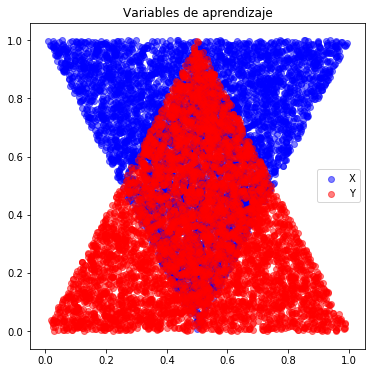

In [11]:
plt.figure(figsize=(6,6))
plt.title("Variables de aprendizaje")
plt.scatter(x=puntos_X[:,0], y=puntos_X[:,1], c='blue', alpha=0.5, label='X')
plt.scatter(x=puntos_Y[:,0], y=puntos_Y[:,1], c='red', alpha=0.5, label='Y')
plt.legend();

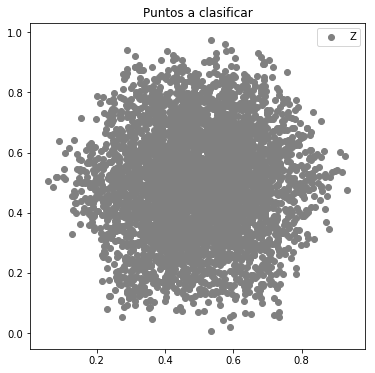

In [12]:
plt.figure(figsize=(6,6))
plt.title("Puntos a clasificar")
plt.scatter(x=puntos_a_clasificar[:, 0], y=puntos_a_clasificar[:, 1], c='gray', label="Z")
plt.legend();

In [13]:
# Generar el histograma partiendo en intervalos a partir de los puntos de X e Y
histo = generar_histograma(puntos_X, puntos_Y, w, h, hn)

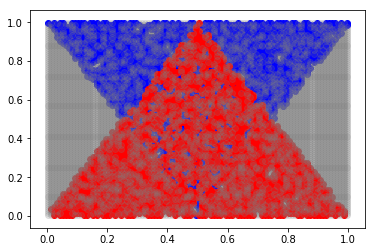

In [15]:
# Realizar un diagrama de Voronoi para ver cómo quedó particionado el espacio por el histograma
diag_voronoi = generar_voronoi(histo, w, h, hn)

clasif_X = np.array([ p for c, p in diag_voronoi if c == "blue"])
clasif_Y = np.array([ p for c, p in diag_voronoi if c == "red"])
clasif_0 = np.array([ p for c, p in diag_voronoi if c == "gray"])
                   
plt.scatter(x=clasif_X[:, 0], y=clasif_X[:, 1], color="blue")
plt.scatter(x=clasif_Y[:, 0], y=clasif_Y[:, 1], color="red")
plt.scatter(x=clasif_0[:, 0], y=clasif_0[:, 1], color="gray", alpha=0.2)

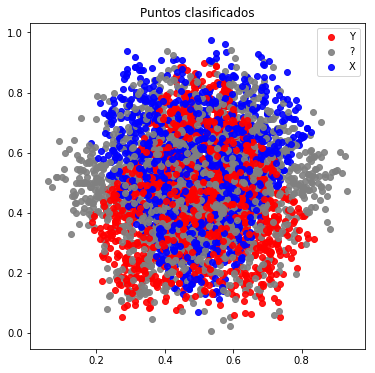

In [16]:
# Clasificar los puntos: Azul = proviene de X, Rojo = proviene de Y, Gris = desconocido (50% chance)
plt.figure(figsize=(6,6))
plt.title("Puntos clasificados")
#plt.scatter(x=puntos_X[:,0], y=puntos_X[:,1], c='blue', alpha=0.15)
#plt.scatter(x=puntos_Y[:,0], y=puntos_Y[:,1], c='red', alpha=0.15)

dibujo_rojo = False
dibujo_azul = False
dibujo_gris = False

for punto in puntos_a_clasificar:
    color = clasificar(punto, histo, w, h, hn)
    
    if color == "red" and not dibujo_rojo:
        plt.scatter(x=punto[0], y=punto[1], c=color, alpha=0.9, label="Y")
        dibujo_rojo = True
    elif color == "blue" and not dibujo_azul:
        plt.scatter(x=punto[0], y=punto[1], c=color, alpha=0.9, label="X")
        dibujo_azul = True
    elif color == "gray" and not dibujo_gris:
        plt.scatter(x=punto[0], y=punto[1], c=color, alpha=0.9, label="?")
        dibujo_gris = True
    else:
        plt.scatter(x=punto[0], y=punto[1], c=color, alpha=0.9)
    
plt.legend();